# Gridded data: Examples with remote sensing data using xarray and remote access

8/23/2019

- Emilio Mayorga
- Chelle Gentemann

[OceanHackWeek 2019](https://oceanhackweek.github.io/)

# NOTES

## TO-DOs
- Change one or more of the plots to use cartopy with coastlines and gridlines
- Mention https://podaac.jpl.nasa.gov/ in the notebook, and add instructions to go there briefly to show the user-facing applications available, and the usual mix of starting with online applications and switching to programmatic access
- **Add [NOAA CoastWatch ERDDAP](https://coastwatch.pfeg.noaa.gov/erddap/) remote sensing dataset example**
    - Show quick search onilne via ERDDAP (makes it easier to explain)
      - Search datasets for "viirs chlorophyll"
      - Point out occurrence of DEPRECATED and EXPERIMENTAL datasets, then remove those from the search with -DEPRECATED -EXPERIMENTAL
    - Select pmlEsaCCI31OceanColor8Day (b/c it's probably not available at the podaac)
    - Say that the same search could be done with erddapy or "requests":
      https://coastwatch.pfeg.noaa.gov/erddap/search/index.html?page=1&itemsPerPage=1000&searchFor=viirs+chlorophyll+-DEPRECATED+-EXPERIMENTAL
    - But just grab the ".dods" url to pass to xarray.ds_open:
      https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI31OceanColor8Day.dods
- Add a small set of "additional resources"
    - Mention or link to ocean.pangeo notebook `noaa_ersst_variability.ipynb`
    - xarray and other resources listed in Chelle's original notebook

## Acknowledgments
- Lineage: https://github.com/cgentemann/cloud_science/blob/master/ocean_python_tutorial/Intro_07_Xarray_and_plotting_with_cartopy.ipynb (note that the original url has changed, and the "-features_new" notebook has disappeared)
  - See https://nbviewer.jupyter.org/github/cgentemann/cloud_science/tree/master/Cloud_testing/ and https://nbviewer.jupyter.org/github/cgentemann/cloud_science/tree/master/ocean_python_tutorial/
- Make Chelle co-author / co-tutor -- the bulk of the notebook came from her!
- Lewis (and his PODAAC affilitation) for podaacpy examples.

## Structure of this tutorial

1. Opening data
3. Advanced data plotting and exploration
4. Collocating satellite data with a cruise dataset

-------------------

# Tutorial

## Import packages

In [1]:
# from urllib.request import urljoin

In [2]:
import warnings
warnings.simplefilter('ignore') # filter some warning messages

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

In [3]:
from pathlib import Path
import configparser
from lxml import objectify

In [4]:
import podaac.podaac as podaac
# to obtain rich information from PO.DAAC Drive, import and create an instance of Drive
from podaac import drive as podaacdrive

## Querying the NASA PO.DAAC catalog with `podaacpy` package

In [5]:
def get_podaac_datasetid(dresult):
    dresult_xml = objectify.fromstring(dresult)
    # But note that there can be multiple entry instances, so list handling would be needed, generically
    # Actually, the "podaac:datasetId" element would probably be more correct than "id"
    dataset_id = dresult_xml.entry.id.text
    # dataset_shortname = dresult_xml.sho
    return dataset_id

In [6]:
basepath = Path('.')

In [7]:
# for search capabilites import podaacpy
# then create an instance of the Podaac class
p = podaac.Podaac()

- Authentication credentials are provided in the 'podaac.ini' file: `d = drive.Drive('podaac.ini', None, None)`
- Looks like podaacpy drive can only read `podaac.ini` from a hard-wired path within the package installation, `site-packages/podaac/tests`.

In [8]:
with open(basepath / 'podaac.ini', 'r') as f:
    config = configparser.ConfigParser()
    config.read_file(f)
    d = podaacdrive.Drive(None, 
                          config['drive']['urs_username'], 
                          config['drive']['urs_password'])

In [9]:
# EM: this is not currently used
dresult = p.dataset_search(keyword='mur',
                           start_time='2018-09-01T00:00:00Z',
                           end_time='2018-09-15T23:59:59Z')

`dresult` is an XML response as a string

In [10]:
dataset_id = get_podaac_datasetid(dresult)
dataset_id

'PODAAC-GHGMR-4FJ04'

In [11]:
gresult = p.granule_search(dataset_id=dataset_id,
                           start_time='2018-09-01T00:00:00Z',
                           end_time='2018-09-15T23:59:59Z')

In [12]:
# we provide a convenience function which enables easy access to all Drive urls
urls = d.mine_drive_urls_from_granule_search(granule_search_response=gresult)

In [13]:
type(urls), len(urls)

(list, 7)

In [14]:
urls

['https://podaac-tools.jpl.nasa.gov/drive/files/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/244/20180901090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://podaac-tools.jpl.nasa.gov/drive/files/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/245/20180902090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://podaac-tools.jpl.nasa.gov/drive/files/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/246/20180903090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://podaac-tools.jpl.nasa.gov/drive/files/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/247/20180904090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://podaac-tools.jpl.nasa.gov/drive/files/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/248/20180905090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://podaac-tools.jpl.nasa.gov/drive/files/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/249/20180906090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'ht

**It's odd that the granules returned, while being daily, stop seven days before the requested end_time. Ask about this.**

The filename encodes the granule timestamp, but we could also use OPeNDAP to open each dataset remotely and query its timestamp directly.

In [15]:
urls_mur = [w.replace('-tools.jpl.nasa.gov/drive/files/', '-opendap.jpl.nasa.gov/opendap/') 
            for w in urls]

## 2. Examining your data

* With well designed mdatasets that follow Climate Forecast (CF) conventions, you will usually get coordinates of lat,lon,time which makes it easy to select data and visualize it in different ways.  
* Notice that the time is automatically converted into a np.datetime64 format which can be queried for month, day, etc.  All the variables that are CF compliant are automatically converted (if needed) and read in so that you can immediately start working with the data.  
* Above, you can see that the dimensions are lat, lon, and time
* The coordinates of the datasets are also lat,lon, and time


use [xr.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) to open the provided url and print the dataset

* url is a text string to an online dataset.  When you open a file, you can just use the file name and path or you can just use the url for files that are available online.  If you are running this on the cloud you could even call cloud located data
* Here, we are reading in a global SST dataset called CMC from NASA's PO.DAAC
   

## Let's open a SST dataset
Below, let's open MUR SSTs using xarray and a PODAAC OpenDAP URL.
To open a file use [xr.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)

The url filename we want to use is already included for you.  You can give a local filename or an opendap URL.

Then just print out the file details by just typing the dataset name, ds_sst_mur

## Metadata --- Examining your data


* The data variable (analysed_sst) has the labeled dimensions and metadata attached.  You can see additional metadata (if it exists) by looking at the data variable of interest.

In [16]:
ds_sst_mur = xr.open_dataset(urls_mur[0])

ds_sst_mur

<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2018-09-01T09:00:00
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -179.99 -179.98 -179.97 ... 179.99 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] ...
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
  

In [17]:
# size in MB
ds_sst_mur.nbytes/1e6 

15551.352004

**That's 15 GB's!** We definitely don't want to download all that data or define processing steps that effectively try to load all the data. So, we'll define a geographical subset.

## Plot the SST.  
### Notice xarray adds labels and title to the plot and colorbar.  

Sometimes the metadata is great and you get exactly the label you need, but sometimes you want to change the label.  Xarray plotting [help](http://xarray.pydata.org/en/stable/plotting.html). A really nice feature of xarray is that it uses the metadata to label the axis.  Let's change the colorbar label by changing the `long_name` attribute

In [18]:
#print out the attributes for `analysed_sst`
ds_sst_mur.analysed_sst.attrs

OrderedDict([('long_name', 'analysed sea surface temperature'),
             ('standard_name', 'sea_surface_foundation_temperature'),
             ('units', 'kelvin'),
             ('valid_min', -32767),
             ('valid_max', 32767),
             ('comment',
              '"Final" version using Multi-Resolution Variational Analysis (MRVA) method for interpolation'),
             ('source',
              'MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRR19_G-NAVO, AVHRRMTA_G-NAVO, iQUAM-NOAA/NESDIS, Ice_Conc-OSISAF')])

In [19]:
ds_sst_mur.analysed_sst

<xarray.DataArray 'analysed_sst' (time: 1, lat: 17999, lon: 36000)>
[647964000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2018-09-01T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -179.99 -179.98 -179.97 ... 179.98 179.99 180.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRR19_G-NAVO, AV...

## Mask out land values using .where

In [20]:
# ds_sst_masked = ds_sst_mur.where(ds_sst_mur.mask==1)
# ds_sst_masked.analysed_sst.plot()

## Subset the data using .sel to the North Atlantic region

In [21]:
# (lat=slice(15,45), lon=slice(-100,-40)
sel_bbox = dict(lat=slice(15,30),lon=slice(-85,-70))

In [22]:
# This statement generates an indexing or memory error
# subset_mur = ds_sst_masked.sel(lat=slice(15,45),lon=slice(-100,-40))
subset_mur_unmasked = ds_sst_mur.sel(**sel_bbox)

subset_mur = subset_mur_unmasked.where(subset_mur_unmasked.mask==1)

In [23]:
# size in MB
subset_mur.nbytes/1e6

54.08404

In [24]:
subset_mur.load()

<xarray.Dataset>
Dimensions:           (lat: 1501, lon: 1501, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2018-09-01T09:00:00
  * lat               (lat) float32 15.0 15.01 15.02 15.03 ... 29.98 29.99 30.0
  * lon               (lon) float32 -85.0 -84.99 -84.98 ... -70.02 -70.01 -70.0
Data variables:
    analysed_sst      (time, lat, lon) float32 nan nan nan ... 302.957 302.979
    analysis_error    (time, lat, lon) float32 nan nan nan ... 0.38 0.38 0.38
    mask              (time, lat, lon) float32 nan nan nan nan ... 1.0 1.0 1.0
    sea_ice_fraction  (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    dt_1km_data       (time, lat, lon) timedelta64[ns] NaT ... -2 days +18:00:00
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    in

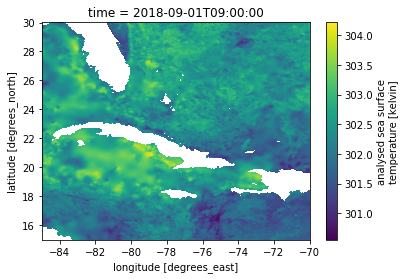

In [25]:
subset_mur.analysed_sst.plot()

### Now search for and handle another dataset, OSTIA

In [26]:
dresult_ostia = p.dataset_search(keyword='ostia',
                                 start_time='2018-09-01T00:00:00Z',
                                 end_time='2018-09-15T23:59:59Z')

In [27]:
dataset_id_ostia = get_podaac_datasetid(dresult_ostia)
dataset_id_ostia

'PODAAC-GHOST-4FK02'

In [28]:
gresult_ostia = p.granule_search(dataset_id=dataset_id_ostia,
                           start_time='2018-09-01T00:00:00Z',
                           end_time='2018-09-15T23:59:59Z')  # originally 2018-09-30T23:59:59Z

#use podaac drive to find we provide a convenience function which enables easy access to all Drive urls
urls = d.mine_drive_urls_from_granule_search(granule_search_response=gresult_ostia)
urls_ostia = [w.replace('-tools.jpl.nasa.gov/drive/files/', '-opendap.jpl.nasa.gov/opendap/') for w in urls]
urls_ostia

['https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/243/20180831120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/244/20180901120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/245/20180902120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/246/20180903120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/247/20180904120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/248/20180905120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02

In [29]:
#'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/255/20180912120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc'
ds_sst_ostia = xr.open_dataset(urls_ostia[1])
subset_ostia = ds_sst_ostia.sel(**sel_bbox)

In [30]:
# size in MB
subset_ostia.nbytes/1e6

1.442408

In [31]:
subset_ostia.load()

<xarray.Dataset>
Dimensions:           (lat: 300, lon: 300, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2018-09-01T12:00:00
  * lat               (lat) float32 15.025 15.075 15.125 ... 29.925 29.975
  * lon               (lon) float32 -84.975 -84.925 -84.875 ... -70.075 -70.025
Data variables:
    analysed_sst      (time, lat, lon) float32 nan nan nan ... 302.4 302.41
    analysis_error    (time, lat, lon) float32 nan nan nan ... 0.19 0.19 0.19
    sea_ice_fraction  (time, lat, lon) float32 nan nan nan nan ... 0.0 0.0 0.0
    mask              (time, lat, lon) float32 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0
Attributes:
    Conventions:                CF-1.4
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST product
    references:                 Donlon, C.J., Martin, M., Stark, J.D., Robert...
    institution:                UKMO
    history:                    Created 

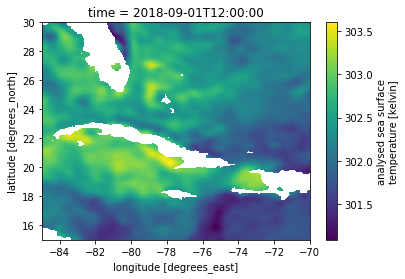

In [32]:
subset_ostia.analysed_sst.plot()

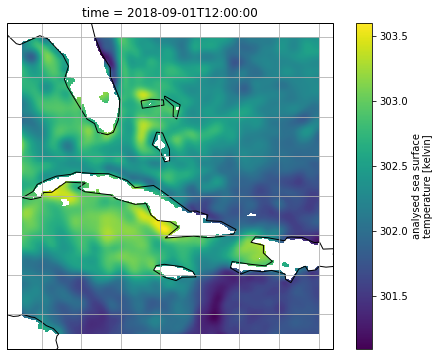

In [33]:
f = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
# subset_ostia.analysed_sst.plot(ax=ax, transform=ccrs.PlateCarree())
subset_ostia.analysed_sst.plot(ax=ax)
# Actually, the cartopy coastline is awful at this scale ...
# And note that axis labels are omitted by default
ax.coastlines(); ax.gridlines();
# ax.set_xlim(-170,-110); ax.set_ylim(20,50)

## Compare the two datasets by regridding MUR to OSTIA's grid
Regridding will allow us to make a direct comparison (via a simple difference), and to use OSTIA's nicer land mask. Regridding will be done using `interp_like`.

## Interpolation and masking

* subset the data, interpolate it onto the ostia grid, then mask it.
* mask ostia 

In [34]:
#use interp_like to automatically interpolate the data in time and space, but here only space
subset_mur_interp = subset_mur.isel(time=0).interp_like(subset_ostia)

# use interp to interpolate the mur data in space onto the ostia grid
#subset_mur_interp = subset_mur.interp(lat=subset_ostia.lat,lon=subset_ostia.lon)
# now use the ostia mask on the interpolated mur sst data
subset_mur_masked = subset_mur_interp.where(subset_ostia.mask==1)

In [35]:
# print out the lat and lon for each dataset, to show they're now on the same grid
print(subset_mur_masked.lon[0:10].data)
print(subset_ostia.lon[0:10].data)
print(subset_mur_masked.lat[0:10].data)
print(subset_ostia.lat[0:10].data)

[-84.97499847 -84.92500305 -84.875      -84.82499695 -84.77500153
 -84.72499847 -84.67500305 -84.625      -84.57499695 -84.52500153]
[-84.975 -84.925 -84.875 -84.825 -84.775 -84.725 -84.675 -84.625 -84.575
 -84.525]
[15.02499962 15.07499981 15.125      15.17500019 15.22500038 15.27499962
 15.32499981 15.375      15.42500019 15.47500038]
[15.025 15.075 15.125 15.175 15.225 15.275 15.325 15.375 15.425 15.475]


In [36]:
subset_ostia.analysed_sst

<xarray.DataArray 'analysed_sst' (time: 1, lat: 300, lon: 300)>
array([[[      nan,       nan, ..., 301.69998, 301.71   ],
        [      nan,       nan, ..., 301.71   , 301.71   ],
        ...,
        [      nan,       nan, ..., 302.4    , 302.41   ],
        [      nan,       nan, ..., 302.4    , 302.41   ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-01T12:00:00
  * lat      (lat) float32 15.025 15.075 15.125 15.175 ... 29.875 29.925 29.975
  * lon      (lon) float32 -84.975 -84.925 -84.875 ... -70.125 -70.075 -70.025
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -300
    valid_max:      4500
    source:         AVHRR18_G-NAVO-L2P-V1.0, AVHRR19_G-NAVO-L2P-V1.0, AVHRR_S...
    reference:      C.J. Donlon, M. Martin,J.D. Stark, J. Roberts-Jones, E. F...
    comment:         OSTIA foundation SST

In [37]:
subset_ostia.analysed_sst.dtype, subset_mur_masked.analysed_sst.dtype

(dtype('float32'), dtype('float64'))

In [38]:
diff = subset_ostia.analysed_sst - subset_mur_masked.analysed_sst

In [39]:
diff

<xarray.DataArray 'analysed_sst' (time: 1, lat: 300, lon: 300)>
array([[[      nan,       nan, ...,  0.002485,  0.011751],
        [      nan,       nan, ..., -0.053755, -0.053255],
        ...,
        [      nan,       nan, ..., -0.282763, -0.410481],
        [      nan,       nan, ..., -0.267264, -0.448978]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-09-01T12:00:00
  * lat      (lat) float32 15.025 15.075 15.125 15.175 ... 29.875 29.925 29.975
  * lon      (lon) float32 -84.975 -84.925 -84.875 ... -70.125 -70.075 -70.025

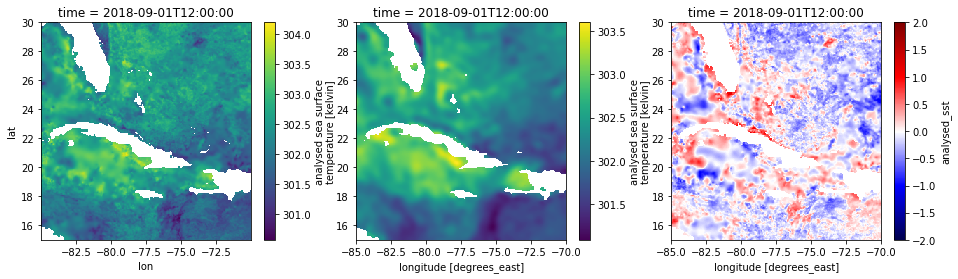

In [40]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

subset_mur_masked.analysed_sst.plot(ax=axes[0])
subset_ostia.analysed_sst.plot(ax=axes[1])
diff.plot(ax=axes[2], vmin=-2, vmax=2, cmap='seismic')

axes[1].set_ylabel('')
axes[2].set_ylabel('');

**NOTES:**
- Odd that on `subset_mur_masked`, the x and y labels got simplified to lon and lat
- change the cmap label/caption in plot 3 so it reflects that it's a diff, and the units

## Histogram and subplots

* Create a figure with two axes using `fig, axes = plt.supplots(ncols=2)`
* To plot on a specific ax you need to set `ax = axes[0]` or `ax = axes[1]` in the hist argument
* Plot the ocean winds histogram on the first axes using [.plot.hist()](http://xarray.pydata.org/en/stable/generated/xarray.plot.hist.html) and the global land/ocean winds on the next
* Change the number of bins using an argument in hist eg.  `bins=20`
* Different [arguments](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist) for .hist  trying making a PDF by using density = True  or change the style of the plot using `histtype = 'step'`

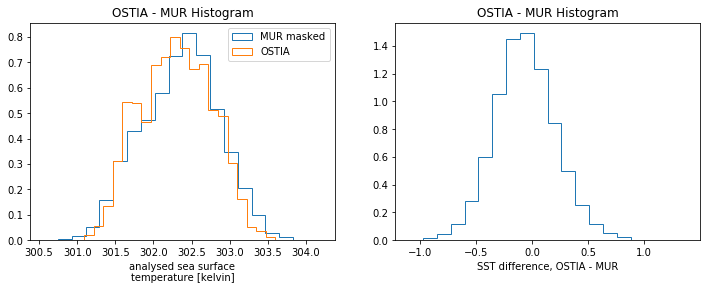

In [41]:
fig, axes = plt.subplots(ncols=2,figsize=(12,4))

subset_mur_masked.analysed_sst.plot.hist(bins=20,ax=axes[0],density = True,histtype='step',
                                         label='MUR masked')
subset_ostia.analysed_sst.plot.hist(bins=20,ax=axes[0],density = True,histtype='step',
                                    label='OSTIA')
diff.plot.hist(bins=20,ax=axes[1],density = True,histtype='step')

axes[0].legend(loc='best')
axes[0].set_title('OSTIA - MUR Histogram')
axes[1].set_xlabel('SST difference, OSTIA - MUR')
axes[1].set_title('OSTIA - MUR Histogram');

## Use xarray and OPeNDAP to open multi-file datasets using lazy loading
When you open a multi-file dataset, xarray uses dask for lasy loading.  
* Lazy loading: It mostly just loads the metadata. You can do data searching, selecting, subsetting without actually loading the data. 
* Here we have loaded in 15 days of data for two very high resolution SST global datasets.  Before we actually load the data, we are going to want to do some subsetting so that it will fit into our memory.
* Notice below when you print out the dataset details that they are all stored as dask.array types.

In [42]:
dsmf_mur = xr.open_mfdataset(urls_mur, coords='minimal')
dsmf_ostia = xr.open_mfdataset(urls_ostia, coords='minimal')

In [43]:
dsmf_mur

<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 7)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -179.99 -179.98 -179.97 ... 179.99 180.0
  * time              (time) datetime64[ns] 2018-09-01T09:00:00 ... 2018-09-07T09:00:00
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<shape=(7, 17999, 36000), chunksize=(1, 17999, 36000)>
    analysis_error    (time, lat, lon) float32 dask.array<shape=(7, 17999, 36000), chunksize=(1, 17999, 36000)>
    mask              (time, lat, lon) float32 dask.array<shape=(7, 17999, 36000), chunksize=(1, 17999, 36000)>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<shape=(7, 17999, 36000), chunksize=(1, 17999, 36000)>
    dt_1km_data       (time, lat, lon) timedelta64[ns] dask.array<shape=(7, 17999, 36000), chunksize=(1, 17999, 36000)>
Attributes:
    Conventions:                CF-1.5
    title:                      Dai

**Compare time series of the cold wake after Hurricane as measured by MUR and OSTIA SSTs**

In [44]:
selmf_bbox = dict(lat=slice(25,26), lon=slice(-61,60))
subsetmf_mur = dsmf_mur.sel(**selmf_bbox).mean({'lat','lon'})
subsetmf_ostia = dsmf_ostia.sel(**selmf_bbox).mean({'lat','lon'})

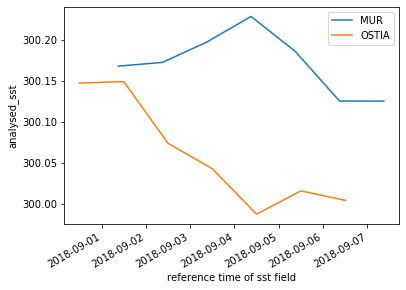

In [45]:
fig, ax = plt.subplots()
subsetmf_mur.analysed_sst.plot(label='MUR')
subsetmf_ostia.analysed_sst.plot(label='OSTIA')
ax.legend();

In [46]:
# Facet plots

# ds_ccmp_ocn = ds_ccmp.where(ds_ccmp.nobs>0,np.nan)
# p = ds_ccmp_ocn.wind_speed.plot(x='lon', y='lat', col='time', transform=ccrs.PlateCarree(),
#                   subplot_kws={'projection': ccrs.Orthographic(-80, 35)})
# for ax in p.axes.flat:
#     ax.coastlines()
#     ax.stock_img();